# Yolov1

Wish you can deepen your understanding of the YOLO model through this tutorial, complete the YOLOV1 model left blank below, and train it on the Penn-Fudan dataset to achieve pedestrian detection.

If you wish to implement it locally or in TSG, please refer to this [Pytorch-YOLOV1 implementation](https://github.com/nsoul97/yolov1_pytorch).





## Dataset preparation

### 1. Download the Dataset
First, let’s download the Pedestrian dataset and extract the zip file:

In [ ]:
import os
import platform

if platform.system() in ['Linux', 'Darwin']:
    os.system('wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data')
    os.system('cd data && unzip PennFudanPed.zip')
elif platform.system() == 'Windows':
    os.system('curl https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -o data/PennFudanPed.zip')
    os.system('cd data && tar -xf PennFudanPed.zip')

### 2. Convert dataset format(txt to xml)


Convert the Penn-Fudan dataset to the VOC dataset format and divide it into training and test sets. Convert the image format in the Penn-Fudan dataset from png to jpg, and extract the boundingbox information in the txt format in the Penn-Fudan dataset and convert it to xml file format.




In [ ]:

import os
import xml.etree.ElementTree as ET
from PIL import Image
import numpy as np
import shutil

# Penn-Fudan dataset path
dataset_path = "data/PennFudanPed"
output_path = "data/VOC_Detection"

# Create target folder structure
for split in ['train', 'test']:
    os.makedirs(os.path.join(output_path, split, "targets"), exist_ok=True)
    os.makedirs(os.path.join(output_path, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(output_path, split, "ImageSets/Main"), exist_ok=True)

# Get lists of image and mask files
image_dir = os.path.join(dataset_path, "PNGImages")
mask_dir = os.path.join(dataset_path, "PedMasks")
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

# Ensure the number of images and masks match
assert len(image_files) == len(mask_files), "Number of images and masks do not match!"

# Split into training and test sets
train_files = image_files[:-50]  # Use earlier samples as training set
test_files = image_files[-50:]   # Use last 50 samples as test set

# Dataset split dictionary
split_dict = {
    'train': train_files,
    'test': test_files
}

# Process each dataset split
for split, files in split_dict.items():
    print(f"Processing {split} dataset...")

    # Generate XML files and copy images for current split
    for image_file in files:
        mask_file = image_file.replace('.png', '_mask.png')

        # Load image and mask
        image_path = os.path.join(image_dir, image_file)
        mask_path = os.path.join(mask_dir, mask_file)
        image = Image.open(image_path)
        mask = Image.open(mask_path)

        # Get image dimensions
        width, height = image.size

        # Create XML root node
        annotation = ET.Element("targets")
        ET.SubElement(annotation, "folder").text = f"data/VOC_Detection/{split}"
        ET.SubElement(annotation, "filename").text = image_file.replace(".png", ".jpg")
        size = ET.SubElement(annotation, "size")
        ET.SubElement(size, "width").text = str(width)
        ET.SubElement(size, "height").text = str(height)
        ET.SubElement(size, "depth").text = "3"

        # Extract bounding box for each person
        mask_np = np.array(mask)
        object_ids = np.unique(mask_np)
        for obj_id in object_ids:
            if obj_id == 0:  # Skip background
                continue
            # Get mask for current object
            obj_mask = (mask_np == obj_id).astype(np.uint8)
            ys, xs = np.where(obj_mask)
            xmin, ymin, xmax, ymax = xs.min(), ys.min(), xs.max(), ys.max()

            # Create object node
            obj = ET.SubElement(annotation, "object")
            ET.SubElement(obj, "name").text = "person"
            ET.SubElement(obj, "pose").text = "Unspecified"
            ET.SubElement(obj, "truncated").text = "0"
            ET.SubElement(obj, "difficult").text = "0"
            bndbox = ET.SubElement(obj, "bndbox")
            ET.SubElement(bndbox, "xmin").text = str(xmin)
            ET.SubElement(bndbox, "ymin").text = str(ymin)
            ET.SubElement(bndbox, "xmax").text = str(xmax)
            ET.SubElement(bndbox, "ymax").text = str(ymax)

        # Save XML file to corresponding split directory
        xml_filename = os.path.join(output_path, split, "targets",
                                  image_file.replace(".png", ".xml"))
        tree = ET.ElementTree(annotation)
        tree.write(xml_filename)

        # Copy image file to corresponding split directory
        output_image_path = os.path.join(output_path, split, "images",
                                       image_file.replace(".png", ".jpg"))
        image.save(output_image_path)

        # Generate image set file
        image_set_file = os.path.join(output_path, split, "ImageSets/Main",
                                     f"{split}.txt")
        with open(image_set_file, "w") as f:
            f.write("\n".join([f.replace(".png", "") for f in files]))

    print(f"{split} dataset processing completed!")

print("All datasets processing completed!")

# Print dataset statistics
print("\nDataset Statistics:")
print(f"Training set size: {len(train_files)}")
print(f"Test set size: {len(test_files)}")

Simplify the .xml format of the targets to preserve only the label and the coordinates of the bounding boxes for each image. For each bounding box in an image a new .csv file with the same name is created. The first row of the .csv file contains the header and the next rows have the format '*object, xmin, ymin, xmax, ymax*'. The old .xml annotation files are deleted.

In [ ]:
import os
import argparse
import xml.etree.ElementTree as Et



def parse_args():
    parser = argparse.ArgumentParser(description='Dataset preparation')

    parser.add_argument('dataset_path', type=str)

    args = parser.parse_args()
    return args.dataset_path


def simplify_targets(dataset_path: str) -> None:
    for dataset_part_dir in ['train', 'test']:
        annot_dir_name = os.path.join(dataset_path, "VOC_Detection", dataset_part_dir, "targets")
        for annot_file_name in os.listdir(annot_dir_name):

            csv_filename = os.path.join(annot_dir_name, f'{annot_file_name[:-4]}.csv')
            xml_filename = os.path.join(annot_dir_name, annot_file_name)

            with open(csv_filename, 'w') as csv_file:
                csv_file.write("object,xmin,ymin,xmax,ymax")
                with open(xml_filename, 'r') as xml_file:
                    for obj in Et.parse(xml_file).getroot().findall('object'):
                        difficult_flag = obj.find('difficult').text
                        if difficult_flag == '0':
                            label = obj.find('name').text
                            bbox_dict = {bndbox.tag: bndbox.text for bndbox in obj.find('bndbox')}
                            csv_file.write(f"\n{label},"
                                           f"{bbox_dict['xmin']},{bbox_dict['ymin']},"
                                           f"{bbox_dict['xmax']},{bbox_dict['ymax']}")
            os.remove(xml_filename)


if __name__ == '__main__':
    dataset_path = "data"
    simplify_targets(dataset_path)

###3. Define the Dataset
Next, we need to write a class for this dataset. As the code below, we wrap images, bounding boxes into torchvision.tv_tensors.

In [ ]:
import torch as th
from torch.utils.data import Dataset
import os
import PIL.Image as Image
import csv
from typing import Callable, Optional, Tuple, Union, List
import xml.etree.ElementTree as ET
from typing import Dict, List, Tuple
import os

class VOC_Detection(Dataset):
    """
    A custom Dataset for the VOC Detection data. An index number (starting from 0) and a color is assigned to each of
    the labels of the dataset.
    """
    C = 1

    index2label = ["person"]

    label2index = {label: index for index, label in enumerate(index2label)}

    label_clrs = ["#ff0000"]


    def __init__(self, root_dir: str, split: str = 'train',
                 transforms: Optional[Callable] = None) -> None:
        """ Initialize the VOC_Detection Dataset object.

        :param root_dir: The root directory of the dataset (this directory contains two directories 'train/' and
                         'test/'.
        :param split: The split of the dataset ('train' or 'test')
        :param transforms: The transforms that are applied to the images (x) and their corresponding targets (y).
        """

        assert split == 'train' or split == 'test'
        split_dir = os.path.join(root_dir, split)

        self.img_dir = os.path.join(split_dir, "images")
        self.annot_dir = os.path.join(split_dir, "targets")
        #self.image_list = self._load_image_list()
        self.pseudonyms = [filename[:-4] for filename in os.listdir(self.annot_dir)]


        self.transforms = transforms



    def __len__(self) -> int:
        """
        Return the total number of instances of the dataset.

        :return: total instances of the dataset
        """
        return len(self.pseudonyms)

    def __getitem__(self, idx: int) -> Tuple[Union[th.Tensor, Image.Image], th.Tensor]:
        """
        Given an index number in range [0, dataset's length) , return the corresponding image and target of the dataset.
        If transforms is defined, the images and their targets are first transformed and then return by the function.

        :param idx: The given index number
        :return: The (x,y)-pair of the image and the target
        """
        pid = self.pseudonyms[idx]
        img_path = os.path.join(self.img_dir, f'{pid}.jpg')
        annot_path = os.path.join(self.annot_dir, f'{pid}.csv')

        img = Image.open(img_path)
        target = []
        with open(annot_path, 'r') as csv_file:
            csv_reader = csv.reader(csv_file)
            next(csv_reader)                    # Remove the header
            for row in csv_reader:
                target.append([self.label2index[row[0]]] + [int(row[i]) for i in range(1, 5)])
        target = th.Tensor(target)

        if len(target) == 0:
          target = th.zeros((0, 5))

        if self.transforms is not None:
            img, target = self.transforms((img, target))

        return img, target

## Yolov1 Introduction
The structural diagram of YoloV1 is shown in the following figure:
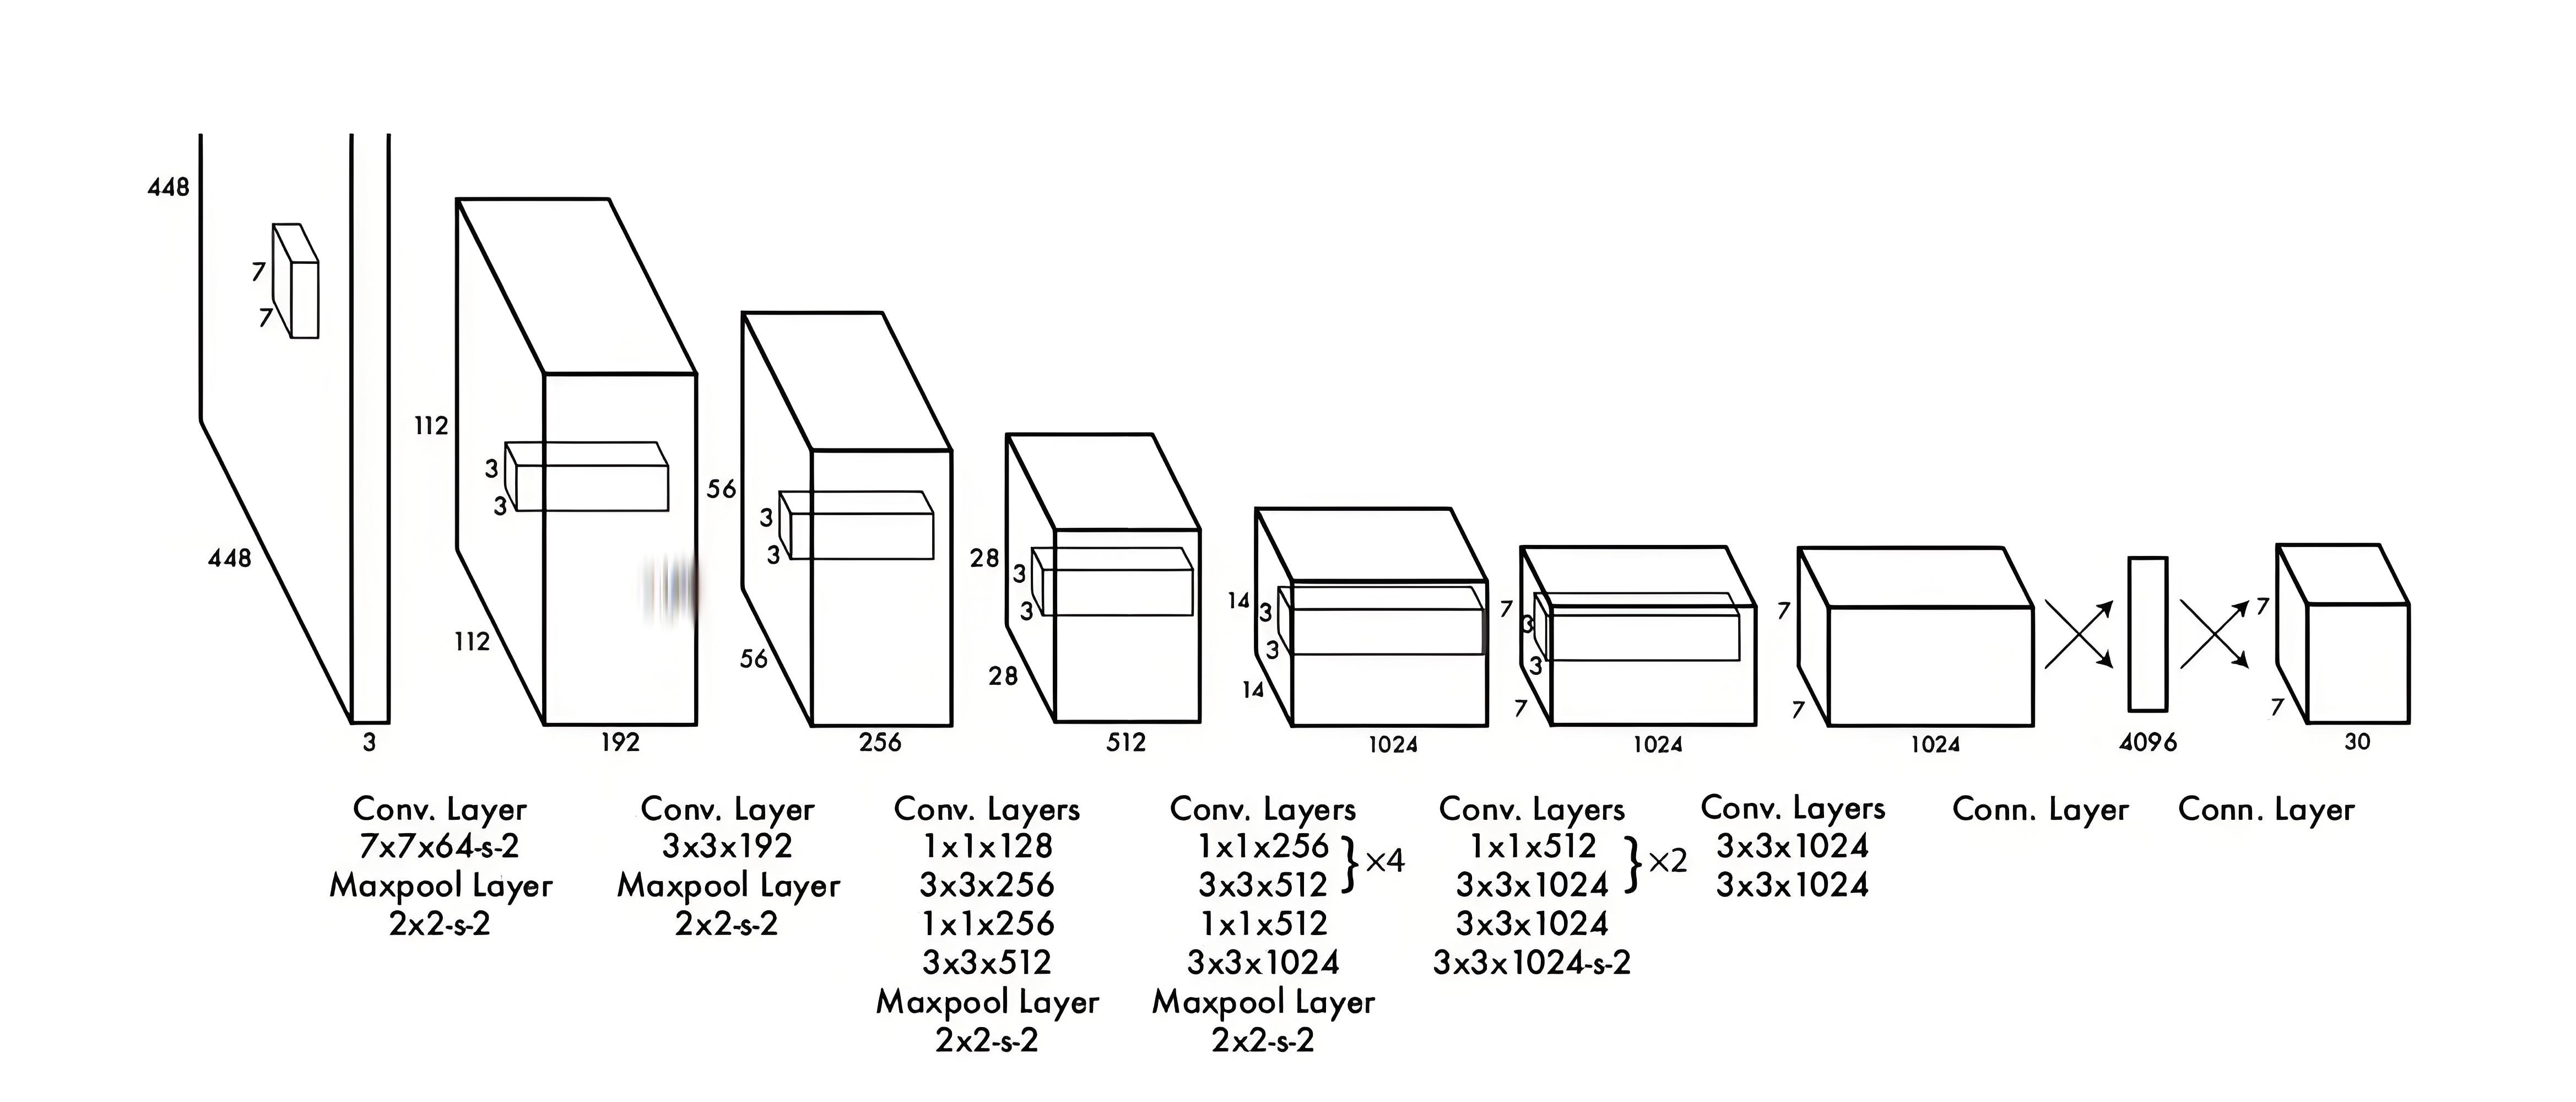



YOLOv1 consists of two main components:


*   Feature Extraction Network：
    *   A convolutional neural network (CNN) is used to extract spatial features from the input image.
    *   The architecture is inspired by GoogLeNet but is more lightweight.
*   Detection Head
    *   Converts the extracted features into predictions, including bounding box coordinates, confidence scores, and class probabilities.



The following is the main code for building the YoloV1 model:

YOLOv1 Model：


*   **Backbone:** A series of convolutional modules for feature extraction.
*   **Detection Head:** Additional convolutional layers and a fully connected layer for predicting bounding boxes, class probabilities, and confidence scores.
*   **Classification Head:** A simpler head for image classification tasks.

LocallyConnected2d Layer:


*   A custom 2D layer similar to a convolutional layer but without weight sharing. Each spatial position has its own set of weights and biases.
*   Used in the detection head of the YOLOv1 model for fine-grained feature extraction.


ConvModule:


*   A modular implementation of convolutional layers and max-pooling layers.
*   Supports configurations for stacking multiple layers, including repeated blocks of layers.
*   Includes batch normalization and Leaky ReLU activation for convolutional layers.





## Build YOLOV1（Include parts that need to be completed）
Please note that the code below is not a complete implementation.

Hope you can supplement the following code through your understanding of YOLOV1.

In the construction of **backbone**, **detection heads**, and **classification heads**, we hope that you can complete the corresponding function writing through the prompts given. You can find them by searching 'TODO'.



In [ ]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from math import ceil, floor
from typing import Optional, List, Tuple, Union

class LocallyConnected2d(nn.Module):
    """
    A Locally Connected 2D Layer behaves like a 2D Convolution Module, with the important distinction that the weights
    are not shared. Instead, each window position has its own set of weights.
    """

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 input_h: int,
                 input_w: int,
                 kernel_size: int,
                 stride: Optional[int] = 1,
                 padding: Optional[int] = 0) -> None:
        """
        Initialize the Locally Connected 2D Layer. The input of the layer is a Tensor with dimensions (N, C, H, W)
        and the output is a Tensor with dimensions (N, C', H', W'), where:

            - C' = output_channels
            - H' = floor( (H + 2 * padding - kernel_size) / stride + 1 )
            - W' = floor( (W + 2 * padding - kernel_size) / stride + 1 )

        :param in_channels: The input channels of the Locally Connected 2D layer
        :param out_channels: The output channels (#filters) of the Locally Connected 2D layer
        :param input_h: The height H of the input tensors that have shape (N, C, H, W)
        :param input_w: The width W of the input tensors that have shape (N, C, H, W)
        :param kernel_size: The size of the kernel. Each filter has dimensions (C x kernel_size x kernel_size)
        :param stride: The stride based on which the patches are extracted.
        :param padding: The padding that will be applied to the left, right, top and bottom of the input Tensors
        """
        super(LocallyConnected2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels #C'
        self.output_h = floor((input_h + 2 * padding - kernel_size) / stride + 1)  #H'
        self.output_w = floor((input_w + 2 * padding - kernel_size) / stride + 1)  #W'
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.weight = nn.Parameter(th.randn(1, self.in_channels, self.out_channels,
                                            self.output_h, self.output_w,
                                            self.kernel_size, self.kernel_size))

        self.bias = nn.Parameter(th.randn(1, self.out_channels, self.output_h, self.output_w))

    def forward(self, x: th.Tensor) -> th.Tensor:
        """
        The windows are extracted like in a 2D Convolution layer, but each window is multiplied with its own set of
        weights. A different bias term is also added for each (patch location, output channel)-combination,

        :param x: The input of the Locally Connected 2D Layer
        :return: The output of the Locally Connected 2D Layer
        """
        x = F.pad(x, (self.padding,) * 4)
        windows = x.unfold(2, self.kernel_size, self.stride).unfold(3, self.kernel_size, self.stride)[:, :, None, ...]
        y = th.sum(self.weight * windows, dim=[1, 5, 6]) + self.bias
        return y


class ConvModule(nn.Module):
    """
    The ConvModule class implements the convolution modules of the Network Design figure in the paper.
    """

    def __init__(self, in_channels: int, module_config: List[Union[List, Tuple]]) -> None:
        """
        The module configuration argument is a list which describes the layers of the module. Each layer is represented
        as a tuple:

        - The Conv. Layers are represented as ('c', kernel_size, out_channels, stride)
        - The MaxPool Layers are represented as ('p', kernel_size, stride)

        When some layers layer_1, ..., layer_m are repeated for k times within a module, they are represented as
        [[layer_1, ..., layer_m], k]

        The height and the width dimensions n of the representation are reduced only due to the strides of either the
        Conv. Layers or the MaxPool Layers. To this end, a padding p is used in the convolutional layers, with:

        p = ceil((f-s) / 2)

        :param in_channels: The input channels of the convolution module
        :param module_config: The module configuration
        """
        super(ConvModule, self).__init__()

        self.layers = []
        for sm_config in module_config:
            if isinstance(sm_config, tuple):
                in_channels = self._add_layer(in_channels, sm_config)
            elif isinstance(sm_config, list):
                sm_layers, r = sm_config
                for _ in range(r):
                    for layer_config in sm_layers:
                        in_channels = self._add_layer(in_channels, layer_config)
            else:
                assert -1
        self.out_channels = in_channels
        self.layers = nn.Sequential(*self.layers)

    def _add_layer(self, in_channels: int, layer_config: Tuple) -> int:
        """
        Add a Conv. Layer or a MaxPool layer to the layers of the Convolution Module.
        The Convolution layers consist of:
            - a 'same' 2D convolution (with/without stride)
            - a Batch Normalization layer
            - a Leaky ReLU activation function with alpha=0.1

        We do not add the bias term in the convolution operation, as it would be zeroed out by the Batch Normalization
        layer.

        The MaxPool layer contains only a single MaxPool operation.

        :param in_channels: The input channels of the layer
        :param layer_config: A tuple that represents the layer configuration
        :return: The output channels of the layer
        """
        if layer_config[0] == 'c':
            kernel_size, out_channels = layer_config[1:3]
            stride = 1 if len(layer_config) == 3 else layer_config[3]
            padding = ceil((kernel_size - stride) / 2)

            layer = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding,
                                            bias=False),
                                  nn.BatchNorm2d(out_channels),
                                  nn.LeakyReLU(0.1))
            nn.init.kaiming_normal_(layer[0].weight, a=0.1, mode='fan_out', nonlinearity='leaky_relu')
            self.layers.append(layer)

            in_channels = out_channels

        elif layer_config[0] == 'p':
            kernel_size, stride = layer_config[1:]
            self.layers.append(nn.MaxPool2d(kernel_size, stride))

        else:
            assert -1

        return in_channels

    def forward(self, x: th.Tensor) -> th.Tensor:
        """
        The input is propagated through the layers of the convolution module sequentially.

        :param x: The input of the convolution module
        :return: The output of the convolution module
        """
        return self.layers(x)

class YOLOv1(nn.Module):
    """
    The YOLOv1 model. The model is pretrained on the Imagenet 2012 Challenge classification task, and it then fine-tuned
    for objection-detection task on the PASCAL VOC dataset.

    The conv_backbone_config consists of the convolution modules that are used both for the classification and the
    detection task.

    The conv_detection_config consists of the convolution modules that are used only for the detection task.

    The last module of the backbone and the first module of the detection head are actually a single module in the
    paper's figure.
    """


    conv_backbone_config = [[('c', 7, 64, 2), ('p', 2, 2)],
                            [('c', 3, 192), ('p', 2, 2)],
                            [('c', 1, 128), ('c', 3, 256), ('c', 1, 256), ('c', 3, 512), ('p', 2, 2)],
                            [[[('c', 1, 256), ('c', 3, 512)], 4], ('c', 1, 512), ('c', 3, 1024), ('p', 2, 2)],
                            [[[('c', 1, 512), ('c', 3, 1024)], 2]]]

    conv_detection_config = [[('c', 3, 1024), ('c', 3, 1024, 2)],
                             [('c', 3, 1024), ('c', 3, 1024)]]

    def __init__(self, S: int, B: int, C: int, mode: Optional[str] = 'detection') -> None:
        """
        The YOLO model's initialization. Depending on the mode of the network, the model's architecture is altered.
        Specifically, for the 'detection' mode, the network consists of the backbone and the detection head.
        For the 'classification' mode, the network consists of the backbone and the classification head.

        :param S: The S parameter of the YOLO model. Each image is split into an (S x S) grid.
        :param B: The B parameter of the YOLO model. The model predicts B bounding boxes for each of the S^2 grid cells.
        :param C: The number of classes for the detection or the classification task
        :param mode: The mode of the YOLO model, either 'detection' (fine-tuning) or 'classification'(pre-training)
        """
        super(YOLOv1, self).__init__()
        self.S = S
        self.B = B
        self.C = C
        self.mode = mode

        backbones_modules_list = []
        in_channels = 3
        for module_config in YOLOv1.conv_backbone_config:
            # TODO: Implement the ConvModule for the backbone
            # Hint: Use the ConvModule class to create convolutional layers based on the module_config.
            #       Append each ConvModule to backbones_modules_list.
            # Replace this line with your implementation： cm =

            backbones_modules_list.append(cm)
            in_channels = cm.out_channels

        self.backbone = nn.Sequential(*backbones_modules_list)

        if mode == 'detection':
            head_modules_list = []
            for module_config in YOLOv1.conv_detection_config:
                cm = ConvModule(in_channels, module_config)
                head_modules_list.append(cm)
                in_channels = cm.out_channels
            detection_conv_modules = nn.Sequential(*head_modules_list)
            detection_fc_modules = nn.Sequential(LocallyConnected2d(in_channels, 256, 7, 7, 3, 1, 1),
                                                 nn.LeakyReLU(0.1),
                                                 nn.Flatten(),
                                                 nn.Dropout(p=0.5),
                                                 nn.Linear(256 * 7 * 7, S * S * (C + B * 5)))

            nn.init.kaiming_normal_(detection_fc_modules[0].weight, a=0.1, mode='fan_out')
            nn.init.zeros_(detection_fc_modules[0].bias)

            self.detection_head = nn.Sequential(detection_conv_modules,
                                                detection_fc_modules)
            self.forward = self._forward_detection

        elif mode == 'classification':
            self.classification_head = nn.Sequential(nn.AvgPool2d(7),
                                                     nn.Flatten(),
                                                     nn.Linear(1024, C))
            self.forward = self._forward_classification

        else:
            assert -1


    def _forward_classification(self, x: th.Tensor) -> th.Tensor:
        """
        The input is propagated through the modules of the backbone and the classification head sequentially.

        :param x: The input of the YOLO model
        :return: The output of the YOLO model for the classification task
        """
        # TODO: Implement the forward pass for classification
        # Hint: Pass the input through the backbone and then the classification head.
        # your own implementation:

        return y

    def _forward_detection(self, x: th.Tensor) -> th.Tensor:
        """
        The input is propagated through the modules of the backbone and the detection head sequentially.

        :param x: The input of the YOLO model
        :return: The output of the YOLO model for the object detection task
        """
        # TODO: Implement the forward pass for detection
        # Hint: Pass the input through the backbone and then the detection head.
        #       Reshape the output to (batch_size, S, S, C + B * 5).
        # your own implementation:


        return y



## Define the loss function of YOLOV1

1. **YOLO Loss Class**


*   **Localization Loss**:
  * Measures how well the predicted bounding boxes match the ground truth
*   **Objectness Loss**:
  * Object presence: Loss when object exists (should match IOU)
  * No object: Loss when no object (should be zero)
* **Classification Loss**:
  * Measures accuracy of class predictions


2. **Helper Functions**: *get_bb_corners* and *iou*:





In [ ]:
import copy
def get_bb_corners(bboxes_coords: th.Tensor) -> th.Tensor:
    """
    Calculate the bounding box corners' coordinates from the YOLO-formatted bounding box coordinates.

    :param bboxes_coords: A Tensor that contains the (x_center, y_center, width, height) center-formatted bounding
    boxes coordinates.
    :return: A Tensor with the same shape as the bboxes_coords Tensor that contains the (xmin, ymin, xmax, ymax)
             corners-formatted bounding box corners' coordinates.
    """

    xmin = bboxes_coords[..., 0] - bboxes_coords[..., 2] / 2
    ymin = bboxes_coords[..., 1] - bboxes_coords[..., 3] / 2
    xmax = bboxes_coords[..., 0] + bboxes_coords[..., 2] / 2
    ymax = bboxes_coords[..., 1] + bboxes_coords[..., 3] / 2

    bb_corners = th.stack([xmin, ymin, xmax, ymax], dim=-1)
    return bb_corners


def iou(bboxes1_coords: th.Tensor, bboxes2_coords: th.Tensor) -> th.Tensor:
    """
    Calculate the intersection over union for the given sets of bounding boxes. The coordinates of each boudning box
    are represented in the corners-format (xmin, ymin, xmax, ymax).

    :param bboxes1_coords: The first set of bounding boxes.
    :param bboxes2_coords: The second set of bounding boxes.
    :return: A Tensor that contains IOU scores for the corresponding bounding boxes of the first and of the second set.
    """
    xmin = th.max(bboxes1_coords[..., 0], bboxes2_coords[..., 0])
    ymin = th.max(bboxes1_coords[..., 1], bboxes2_coords[..., 1])
    xmax = th.min(bboxes1_coords[..., 2], bboxes2_coords[..., 2])
    ymax = th.min(bboxes1_coords[..., 3], bboxes2_coords[..., 3])

    area_bb1 = (bboxes1_coords[..., 2] - bboxes1_coords[..., 0]) * (bboxes1_coords[..., 3] - bboxes1_coords[..., 1])
    area_bb2 = (bboxes2_coords[..., 2] - bboxes2_coords[..., 0]) * (bboxes2_coords[..., 3] - bboxes2_coords[..., 1])

    # clamp(min=0) for the special case: intersection=0
    intersection = (xmax - xmin).clamp(min=0) * (ymax - ymin).clamp(min=0)
    union = area_bb1 + area_bb2 - intersection

    # add 1e-6 to avoid division by 0
    return intersection / (union + 1e-6)


class YOLO_Loss(nn.Module):
    """
    An implementation of the YOLO Loss function. YOLO loss consists of 3 components:
    - the localization loss
    - the objectness loss
    - the classification loss
    """

    def __init__(self, S, C, B, D, L_coord, L_noobj):
        """
        Initialize the YOLO Loss module.

        The L_coord hyperparameter is used, as otherwise the localization and the classification errors would be equally
        weighted, which is not ideal for maximizing the average precision. In this way, the loss from the bounding box
        predictions is increased.

        The majority of the grid cells in every image do not contain any object.  This pushes the “confidence” scores of
        those cells towards zero, often overpowering the gradient from cells that do contain objects. This can lead to
        model instability, causing training to diverge early on. To this end, the  L_noobj hyperparameter is used to
        decrease the objectness loss when an object does not exist in the grid cell.

        :param S: The number of grid cells per row/column. Each image is divided into an (S x S) grid
        :param C: The number of classes
        :param B: The number of the bounding boxes that YOLO predicts per grid cell
        :param D: The input dimension of the (D x D) RGB images
        :param L_coord: The L_coord hyperparameter
        :param L_noobj: The L_noobj hyperparameter
        """
        super(YOLO_Loss, self).__init__()
        self.S = S
        self.B = B
        self.C = C
        self.D = D
        self.L_coord = L_coord
        self.L_noobj = L_noobj

        # The indices for each of the B bounding boxes of the algorithm
        self.register_buffer('pred_bb_ind', th.arange(start=self.C, end=self.C + self.B * 5).reshape(self.B, 5))

    def forward(self, y_pred, y_gt):
        """
        The YOLO loss is the sum of the localization error, the objectness error and classification error. These errors
        are sum-squared because in this way they are easier to optimize.

        In order to identify which of the B output bounding boxes is responsible for predicting the object, we have to
        calculate the IOUs of the B boxes with the ground truth box. Since the center coordinates and the dimensions of
        the bounding box are differently normalized, calculating the corner coordinates without reversing the
        normalization of the values would result to incorrect IOU scores. Therefore, we first calculate the corner
        coordinates of the bounding boxes in the original (D x D) image.

        The box with the highest IOU is selected as responsible for the prediction. If all the B predictions do not
        intersect with the ground truth box, the box with the lowest root-mean-square error is selected, as long as the
        error is less than 20. Otherwise, one of the B bounding boxes is selected randomly.

        Instead of the width and the height of the bounding boxes, the model outputs their corresponding square roots.
        In this way, in the localization error, we do not apply a square root operation, whose gradient at 0 is +inf
        and could be responsible for the divergence of our model.

        For the objectness loss, if an object exists in a grid cell and the bounding box is responsible for the
        prediction, the confidence should be equal to the IOU of the prediction and the ground truth box. Otherwise, the
        confidence should be 0.

        :param y_pred: The (N, S, S, C+B*5) predictions of the YOLO model for a mini-batch of N images
        :param y_gt: The (N, S, S, C+5) ground truth labels of the corresponding images
        :return: The YOLO loss for the given predictions and ground truth labels.
        """
        n = y_pred.shape[0]
        exists_obj_i = y_gt[..., 0:1]
        gt_bboxes_coords = y_gt[..., None, self.C + 1:]
        pred_bboxes_sqrt_coords = y_pred[..., self.pred_bb_ind[:, 1:]]

        gt_bboxes_scaled_coords = copy.deepcopy(gt_bboxes_coords.data)
        gt_bboxes_scaled_coords[..., :2] /= self.S
        gt_bboxes_coords_corners = get_bb_corners(gt_bboxes_scaled_coords)

        pred_bboxes_scaled_coords = copy.deepcopy(pred_bboxes_sqrt_coords.data)
        pred_bboxes_scaled_coords[..., :2] /= self.S
        pred_bboxes_scaled_coords[..., 2:] *= pred_bboxes_scaled_coords[..., 2:]
        pred_bboxes_coords_corners = get_bb_corners(pred_bboxes_scaled_coords)

        iou_scores = iou(gt_bboxes_coords_corners, pred_bboxes_coords_corners)
        max_iou_score, max_iou_index = th.max(iou_scores, dim=-1)

        rmse_scores = th.sqrt(th.sum((gt_bboxes_scaled_coords - pred_bboxes_scaled_coords) ** 2, dim=-1))
        min_rmse_scores, min_rmse_index = th.min(rmse_scores, dim=-1)
        rmse_mask = max_iou_score == 0

        best_index = max_iou_index
        best_index[rmse_mask] = min_rmse_index[rmse_mask]
        is_best_box = one_hot(best_index, self.B)

        exists_obj_ij = exists_obj_i * is_best_box
        exists_noobj_ij = 1 - exists_obj_ij

        # Localization Loss
        localization_center_loss = self.L_coord * th.sum(exists_obj_ij[..., None] * (
                (gt_bboxes_coords[..., 0:2] - pred_bboxes_sqrt_coords[..., 0:2]) ** 2))

        localization_dims_loss = self.L_coord * th.sum(exists_obj_ij[..., None] * (
                (th.sqrt(gt_bboxes_coords[..., 2:4]) - pred_bboxes_sqrt_coords[..., 2:4]) ** 2))

        localization_loss = localization_center_loss + localization_dims_loss

        # Objectness Loss
        pred_bbox_cscores = y_pred[..., self.pred_bb_ind[:, 0]]

        objectness_obj_loss = th.sum(exists_obj_ij * (iou_scores - pred_bbox_cscores) ** 2)
        objectness_noobj_loss = self.L_noobj * th.sum(exists_noobj_ij * pred_bbox_cscores ** 2)

        objectness_loss = objectness_obj_loss + objectness_noobj_loss

        # Classification Loss
        pred_bboxes_class = y_pred[..., :self.C]
        gt_bboxes_class = y_gt[..., 1:self.C + 1]

        classification_loss = th.sum(exists_obj_i * (gt_bboxes_class - pred_bboxes_class) ** 2)

        # Average YOLO Loss per instance
        total_loss = (localization_loss + objectness_loss + classification_loss) / n
        return total_loss

Define some callable classes for image size conversion and data augmentation.

In [ ]:


import torch as th
from torch.nn.functional import one_hot
import torchvision.transforms.functional as fT
from PIL.Image import Image
from typing import Tuple, Optional, List
class Resize:
    """
    A callable Resize class, which upon its call resizes the image and scales the bounding box coordinates
    appropriately.
    """

    def __init__(self, output_size: int) -> None:
        """
        Initialize the dimension d of the image after the transformation. After the image is resized, it will have a
        (d x d) shape.

        :param output_size: The dimension of the image after the transformation.
        """
        self.d = output_size

    def __call__(self, sample: Tuple[Image, th.Tensor]
                 ) -> Tuple[Image, List[Tuple[float, float]], th.Tensor]:
        """
        Resize the image to a (d x d) shape and transform the bounding box coordinates.
        In an image with N objects, the target tensor has a (N x 5)-shape and for each object the target is formatted
        as  <classification_id>, <x_min>, <y_min>, <x_max>, <y_max>. Given an (h x w)-image, the x and y coordinates
        are updated to x' and y' in the following way:

        | x' = x * d / w
        | y' = y * d / h

        :param sample: A tuple containing the image and its corresponding target
        :return: The resized (d x d) image, a mask that contains all the image pixels ([0,d] both in the x- and y-axis)
                 and the appropriately scaled coordinates
        """
        img, target = sample
        w, h = img.size

        img = fT.resize(img, (self.d, self.d))
        target[:, [1, 3]] *= self.d / w
        target[:, [2, 4]] *= self.d / h

        mask = [(0, self.d), (0, self.d)]
        return img, mask, target


class RandomScaleTranslate:
    """
    A callable RandomScaleTranslate class, which resizes the image and scales the bounding box coordinates. In order to
    augment the dataset, for each image we randomly choose between the following operations:

    - resize
    - zoom out & resize
    - zoom in & resize

    When we zoom out, the image will be padded with zeros. To avoid distorting these zero values
    (e.g. RandomColorJitter, normalization), a mask is returned to specify which values were padded.
    """
    def __init__(self,
                 output_size: int,
                 jitter: float,
                 resize_p: float,
                 zoom_out_p: float,
                 zoom_in_p: float) -> None:
        """
        Initialize the dimension d of the image after the transformation. After the image is resized, it will have a
        (d x d) shape. The given jitter factor is also stored to randomly scale and translate the image.
        The probabilities are used to select randomly one of the operations.

        :param output_size: The dimension of the image after the transformation.
        :param jitter: A factor to sample the random scale and translation for the zoom operations
        :param resize_p: The probability that the 'resize' operation is applied
        :param zoom_out_p: The probability that the 'zoom out & resize' operation is applied
        :param zoom_in_p: The probability that the 'zoom in & resize' operation is applied
        """
        self.d = output_size
        self.jitter = jitter
        self.t_probs = th.cumsum(th.Tensor([resize_p, zoom_out_p, zoom_in_p]), dim=0)

    def __call__(self, sample: Tuple[Image, th.Tensor]
                 ) -> Tuple[Image, List[Tuple[float, float]], th.Tensor]:
        """
        Sample from a uniform random distribution whether to apply the 'resize', 'zoom out & resize' or 'zoom in &
        resize' operation. The probability of each operation is equal to the given corresponding value.

        In each case, the image is resized to a (d x d) shape and the bounding box coordinates are transformed
        appropriately. A mask that specifies the bounds of the non-padded values of the image is also returned.
        For the 'resize' and the 'zoom in & resize' operations, this mask contains all the pixel values of the image.

        If a bounding box is very small after the transformation, it is removed from the targets.

        :param sample: A tuple containing the image and its corresponding target
        :return: A tuple containing the transformed image, its mask and the updated corresponding target
        """

        transform_prob = th.rand(1)
        if transform_prob < self.t_probs[0]:                    # resize
            img, mask, target = self._resize(sample)
        elif transform_prob < self.t_probs[1]:                  # zoom out & resize
            img, mask, target = self._zoom_out(sample)
        else:                                                   # zoom in & resize
            img, mask, target = self._zoom_in(sample)

        # Remove very small bounding boxes
        bboxes_w = target[:, 3] - target[:, 1]
        bboxes_h = target[:, 4] - target[:, 2]
        threshold = 0.001 * self.d
        valid_bboxes = th.logical_not(th.logical_or(bboxes_w < threshold, bboxes_h < threshold))
        target = target[valid_bboxes]
        return img, mask, target

    def _resize(self, sample: Tuple[Image, th.Tensor]
                ) -> Tuple[Image, List[Tuple[float, float]], th.Tensor]:
        """
        This function follows the same logic with the __call__ function of the Resize class.

        Resize the image to a (d x d) shape and transform the bounding box coordinates.
        In an image with N objects, the target tensor has a (N x 5)-shape and for each object the target is formatted
        as  <classification_id>, <x_min>, <y_min>, <x_max>, <y_max>. Given an (h x w)-image, the x and y coordinates
        are updated to x' and y' in the following way:

        | x' = x * d / w
        | y' = y * d / h

        :param sample: A tuple containing the image and its corresponding target
        :return: A tuple containing the resized image, its mask and the updated corresponding target
        """
        img, target = sample
        w, h = img.size

        img = fT.resize(img, (self.d, self.d))
        target[:, [1, 3]] *= self.d / w
        target[:, [2, 4]] *= self.d / h

        mask = [(0, self.d), (0, self.d)]
        return img, mask, target

    def _zoom_out(self, sample: Tuple[Image, th.Tensor]
                  ) -> Tuple[Image, List[Tuple[float, float]], th.Tensor]:
        """
        First a new aspect ratio is set by sampling randomly from a uniform distribution rand_w and rand_h:

        - rand_w ~ U((1-jitter)w, (1+jitter)w)
        - rand_h ~ U((1-jitter)h, (1+jitter)h)

        and setting:
         new_ar = rand_w / rand_h

        We compare rand_w with rand_h and set the large dimension's size equal with d. The size of the other dimension
        is calculated based on the aspect ratio. Therefore, the selected image patch has a size of (d, k) or (k,d) with
        k <= 1.

        Following this resize transformation, the image patch is randomly translated. To translate the image patch, we
        pad the image with zeros:
        - left and right, if the image patch has a width of k
        - top and bottom, if the image patch has a height of k.

        We randomly sample how many pixels are padded on the left or the top of the image from U(0, d-k). We also pad
        the image with zeros on the right or the bottom to have a (d x d) shape.

        The transformations that are applied to the coordinates of the image are:
        1) resize from (w,h) to (d,k) or (k,d)
        2) translate the image by the number of padded values on the left or the top of the image
        Therefore, these transformations will be applied to the bounding box coordinates.

        The mask of the transformed image will contain the bounds of the non-padded values with mask = [mask_x, mask_y]

        :param sample: A tuple containing the image and its corresponding target
        :return: A tuple containing the transformed image after the 'zoom out & resize' operation, its mask and the
                 updated corresponding target
        """

        img, target = sample
        w, h = img.size

        dw = w * self.jitter
        dh = h * self.jitter
        rand_w = w + th.Tensor(1).uniform_(-dw, dw)
        rand_h = h + th.Tensor(1).uniform_(-dh, dh)
        new_ar = rand_w / rand_h

        if new_ar < 1:
            nh = self.d
            nw = int(nh * new_ar + 0.5)
        else:
            nw = self.d
            nh = int(nw / new_ar + 0.5)

        dx = th.randint(low=0, high=self.d - nw + 1, size=(1,)).item()
        dy = th.randint(low=0, high=self.d - nh + 1, size=(1,)).item()

        img = fT.resize(img, (nh, nw))
        target[:, [1, 3]] *= nw / w
        target[:, [2, 4]] *= nh / h

        img = fT.pad(img, padding=[dx, dy, self.d - nw - dx, self.d - nh - dy])
        target[:, [1, 3]] += dx
        target[:, [2, 4]] += dy

        mask = [(dx, dx + nw), (dy, dy + nh)]
        return img, mask, target

    def _zoom_in(self, sample: Tuple[Image, th.Tensor]
                 ) -> Tuple[Image, List[Tuple[float, float]], th.Tensor]:
        """
        First we sample the width and height of an image patch, nw and nh respectively, from a uniform random
        distribution:

        - nw ~ U((1-jitter)w, w)
        - nh ~ U((1-jitter)h, h)

        Similarly we sample dx and dy to crop an image patch from the original image.

        - dx ~ U(0, w-nw)
        - dy ~ U(0, h-nh)

        Following that, the selected image patch is resized to a (d x d) shape.

        The bounding box coordinates are transformed in the following way:
        1) the top, left coordinate of the image patch (dx, dy) must be translated to (0,0)
        2) the image patch is resized from a size of (nw, nh) to (d, d)
        The bounding boxes that are not visible after the transformation are completely removed from the targets, while
        the bounding boxes that are only partially visible have their coordinates clamped to be within the image.

        The mask of the transformed image will contain all the pixel values of the image in both the x- and y-axis.

        :param sample: A tuple containing the image and its corresponding target
        :return: A tuple containing the transformed image after the 'zoom in & resize' operation, its mask and the
                 updated corresponding target
        """
        img, target = sample
        w, h = img.size

        nw = int(th.Tensor(1).uniform_((1 - self.jitter) * w, w) + 0.5)
        nh = int(th.Tensor(1).uniform_((1 - self.jitter) * h, h) + 0.5)
        dx = int(th.Tensor(1).uniform_(0, w - nw + 1) + 0.5)
        dy = int(th.Tensor(1).uniform_(0, h - nh + 1) + 0.5)

        img = fT.resized_crop(img, top=dy, left=dx, height=nh, width=nw, size=(self.d, self.d))

        target[:, [1, 3]] -= dx
        target[:, [2, 4]] -= dy
        target[:, [1, 3]] *= self.d / nw
        target[:, [2, 4]] *= self.d / nh

        # Remove bounding boxes that are not visible any more
        target = target[th.logical_not(th.logical_or(th.logical_or(target[:, 3] < 0, target[:, 1] > self.d),
                                                     th.logical_or(target[:, 4] < 0, target[:, 2] > self.d)))]

        # Update the bounds of the bounding boxes that are only partially visible
        target[:, [1, 2]] = target[:, [1, 2]].clamp(min=0)
        target[:, [3, 4]] = target[:, [3, 4]].clamp(max=self.d)

        mask = [(0, self.d), (0, self.d)]
        return img, mask, target


class RandomColorJitter:
    """
    A callable RandomColorJitter class, which when called distorts the colors of the input image. The target values
    remain unchanged.
    """

    def __init__(self, hue: float, sat: float, exp: float):
        """
        Initialize the hue, saturation and exposure parameters.

        :param hue: The hue parameter. The hue value will be sampled uniformly at random from [-hue, hue].
        :param sat: The saturation parameter. The saturation value will be sampled uniformly at random from [1/sat, sat]
        :param exp: The exposure parameter. The exposure parameter will be sampled uniformly at random from [1/exp, exp]
        """
        self.hue = hue
        self.sat = sat
        self.exp = exp

    def __call__(self, sample: Tuple[Image, List[Tuple[float, float]], th.Tensor]
                 ) -> Tuple[Image, List[Tuple[float, float]], th.Tensor]:
        """
        Sample uniformly at random the hue, saturation and exposure values and distort the colors of the input image.
        The hue, saturation and exposure of the image are adjusted in the HSV color space. Specifically:

        HUE
            pixel_H = pixel_H + rand_hue

            if pixel_H > 1, then
                pixel_H = pixel_H - 1
            else if pixel_H < 0, then
                pixel_H = pixel_H + 1

        SATURATION
            pixel_S = min(pixel_S * rand_sat, 1.0)

        EXPOSURE
            pixel_V = min(pixel_V * rand_exp, 1.0)

        :param sample: A tuple containing the image, its mask and the corresponding target
        :return: The distorted image and its (unchanged) target
        """
        # Sample uniformly at random the hue, saturation and exposure values for this image.
        rand_hue = th.Tensor(1).uniform_(-self.hue, self.hue)
        rand_sat = th.Tensor(1).uniform_(1 / self.sat, self.sat)
        rand_exp = th.Tensor(1).uniform_(1 / self.exp, self.exp)

        # Convert the RGB PIL image to an HSV tensor.
        rgb_img, mask, target = sample
        hsv_img = rgb_img.convert('HSV')
        hsv_tensor = fT.to_tensor(hsv_img)

        mask_x, mask_y = mask
        masked_hsv_tensor = hsv_tensor[:, mask_y[0]:mask_y[1], mask_x[0]:mask_x[1]]

        # Adjust hue
        masked_hsv_tensor[0, :, :] += rand_hue
        masked_hsv_tensor[0, :, :] += (1. * (masked_hsv_tensor[0, :, :] < 0) - 1. * \
                                       (masked_hsv_tensor[0, :, :] > 1)) * th.ones_like(masked_hsv_tensor[0, :, :])
        # Adjust saturation
        masked_hsv_tensor[1, :, :] *= rand_sat
        masked_hsv_tensor[1, :, :] = masked_hsv_tensor[1, :, :].clamp(max=1.0)

        # Adjust exposure
        masked_hsv_tensor[2, :, :] *= rand_exp
        masked_hsv_tensor[2, :, :] = masked_hsv_tensor[2, :, :].clamp(max=1.0)

        # Convert the HSV tensor to an RGB PIL image
        hsv_img = fT.to_pil_image(hsv_tensor, mode='HSV')
        rgb_img = hsv_img.convert('RGB')

        return rgb_img, mask, target


class RandomHorizontalFlip:
    """
    A callable RandomHorizontalFlip class. When called, it is randomly chosen whether the image is flipped horizontally.
    When the image is  flipped, the bounding box coordinates and the mask are also transformed appropriately.
    """
    def __init__(self, p: float) -> None:
        """
        Initialize a RandomHorizontalFlip object and set the probability that the image is flipped.

        :param p: The probability that the horizontal flip transformation is applied
        """
        self.p = p

    def __call__(self, sample: Tuple[Image, List[Tuple[float, float]], th.Tensor]
                 ) -> Tuple[Image, List[Tuple[float, float]], th.Tensor]:
        """
        A number in [0,1) is randomly sampled from the uniform distribution U(0,1) to determine if the horizontal flip
        transformation will be applied. The transformation is applied with probability p. If the image is flipped, the
        xmin and xmax coordinates of the bounding boxes are updated. Furthermore, the mask's component in the x-axis
        is also updated similarly.

        :param sample: A tuple containing the image, its mask and the corresponding target
        :return: If the transformation is applied, the horizontally flipped image, the transformed mask and the
                 transformed target is returned. Otherwise, the input sample is returned.
        """
        apply_transform = th.rand(1) < self.p
        if not apply_transform:
            return sample

        img, mask, target = sample
        w = img.size[0]

        target[:, [1, 3]] = w - target[:, [3, 1]]
        img = fT.hflip(img)

        start_x, end_x = mask[0]
        mask[0] = (w - end_x, w - start_x)

        return img, mask, target


class ToYOLOTensor:
    """
    A callable ToYOLOTensor class. When called the targets of the image will be transformed according to the YOLO
    format, while the PIL image will be converted a Tensor. If the mean and the standard deviation of the input image
    channels are provided, the Tensors are normalized.
    """

    def __init__(self, S: int, C: int, normalize: Optional[List] = None) -> None:
        """
        Initialize the number of grid cells per row/column and the number of classes of the dataset.

        :param S: The S parameter of the YOLO algorithm. Each image is split into an (S x S) grid.
        :param C: The number of classes of the dataset.
        :param normalize: A list that contains two lists, one with the 3 mean values of the pixels per channel and
                          another with the corresponding standard deviations per channel.
        """
        self.S = S
        self.C = C
        self.normalize = normalize

    def __call__(self, sample: Tuple[Image, List[Tuple[float, float]], th.Tensor]
                 ) -> Tuple[th.Tensor, th.Tensor]:
        """
        The PIL image input is converted to a Tensor and the tensor is (optionally normalized).
        In an image with N objects, the input target tensor has a (N x 5)-shape and for each object the target is
        formatted as <classification_id>, <x_min>, <y_min>, <x_max>, <y_max>. The output target tensor has shape
        (S x S x C+5). For each of the (S x S) cells of the grid:

        - index 0: 0 or 1 if an object exists in that cell
        - indices [1,C]: one hot representation of the object in the cell or 0s everywhere
        - index C+1: normalized center x-coordinate.
        - index C+2: normalized center y-coordinate.
        - index C+3: normalized width of the bounding box
        - index C+4: normalized height of the bounding box

        The center coordinates are normalized as offsets in the grid where the upper-left corner in the grid has
        coordinates (0,0) and the bottom-right corner in the grid has coordinates (1,1).

        The height and the width of the bounding boxes are normalized by the image height and width.

        :param sample: A tuple containing the image, its mask and the corresponding target
        :return: The given image and its target in a YOLO-grid format.
        """
        img, mask, target = sample
        w, h = img.size

        cell_w = w / self.S
        cell_h = h / self.S

        center_x = (target[:, 1] + target[:, 3]) / 2
        center_y = (target[:, 2] + target[:, 4]) / 2
        bndbox_w = target[:, 3] - target[:, 1]
        bndbox_h = target[:, 4] - target[:, 2]

        label = target[:, 0].long()
        center_col = th.div(center_x, cell_w, rounding_mode="trunc").long()
        center_row = th.div(center_y, cell_h, rounding_mode="trunc").long()
        norm_center_x = (center_x % cell_w) / cell_w
        norm_center_y = (center_y % cell_h) / cell_h
        norm_bndbox_w = bndbox_w / w
        norm_bndbox_h = bndbox_h / h

        target = th.zeros((self.S, self.S, self.C + 5))
        target[center_row, center_col, :] = th.cat([th.ones((label.shape[0], 1)),
                                                    one_hot(label, self.C),
                                                    norm_center_x.unsqueeze(1),
                                                    norm_center_y.unsqueeze(1),
                                                    norm_bndbox_w.unsqueeze(1),
                                                    norm_bndbox_h.unsqueeze(1)],
                                                   dim=1)

        img_tensor = fT.to_tensor(img)
        if self.normalize:
            mask_x, mask_y = mask
            fT.normalize(img_tensor[:, mask_y[0]:mask_y[1], mask_x[0]:mask_x[1]],
                         mean=self.normalize[0],
                         std=self.normalize[1],
                         inplace=True)

        return img_tensor, target



class ImgToTensor:
    """
        A callable ImgToTensor class. When called the PIL image will be converted a Tensor. If the mean and the standard
        deviation of the input image channels are provided, the Tensors are normalized.
        """

    def __init__(self, normalize: Optional[List] = None) -> None:
        """
        Initialize the number of grid cells per row/column and the number of classes of the dataset.

        :param S: The S parameter of the YOLO algorithm. Each image is split into an (S x S) grid.
        :param C: The number of classes of the dataset.
        :param normalize: A list that contains two lists, one with the 3 mean values of the pixels per channel and
                          another with the corresponding standard deviations per channel.
        """
        self.normalize = normalize

    def __call__(self, sample: Tuple[Image, List[Tuple[float, float]], th.Tensor]
                 ) -> Tuple[th.Tensor, th.Tensor]:
        """
        The PIL image input is converted to a Tensor and the tensor is (optionally normalized). The targets are not
        modified.

        :param sample: A tuple containing the image and its corresponding target
        :return: An image tensor and the corresponding targets.
        """
        img, mask, target = sample

        img_tensor = fT.to_tensor(img)
        if self.normalize:
            mask_x, mask_y = mask
            img_tensor[:, mask_y[0]:mask_y[1], mask_x[0]:mask_x[1]] = fT.normalize(img_tensor, mean=self.normalize[0], std=self.normalize[1])
        return img_tensor, target

## Train

You can select 'pretrain', ‘ Train 'or None in the **LOAD_MODEL**. Please note that when you choose 'pretrain' or 'train', please ensure that you have downloaded the [pre training weights or initial weights for YOLOV1](https://github.com/nsoul97/yolov1_pytorch/tree/main/checkpoints) and placed them in the appropriate location.

Fill in the location where your model weights are stored in **TRAINED_MODEL_WEIGTS** and **PRETRAINED_MODEL_WEIGTS** in the code below.



In [ ]:
import torch as th
import torchvision.transforms as transforms
import torch.optim as opt
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm import tqdm
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
from PIL import Image

# Model Hyperparameters
S = 7
B = 2
D = 448

# Loss Function Hyperparameters
L_COORD = 5.0
L_NOOBJ = 0.5

# Data Augmentation Hyperparameters
HUE = 0.1
SATURATION = 1.5
EXPOSURE = 1.5

RESIZE_PROB = 0.2
ZOOM_OUT_PROB = 0.4
ZOOM_IN_PROB = 0.4
JITTER = 0.2

# Data Loading Hyperparameters
BATCH = 64
SUBDIVISIONS = 16 #batch_size=BATCH // SUBDIVISIONS
NUM_WORKERS = 2
SHUFFLE = True
PIN_MEMORY = True
DROP_LAST = True

# Training Hyperparameters
MAX_EPOCHS = 50
INIT_LR = 0.0005
BURN_IN = 10
BURN_IN_POW = 2.
LR_SCHEDULE = [(750, 2.0),  # (step, scale)
               (1500, 2.0),
               (2250, 1.25),
               (3250, 1.60),
               (5500, 1.25),
               (15000, 0.8),
               (20000, 0.625),
               (25000, 0.8),
               (30000, 0.5),
               (35000, 0.5)]
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

# VOC Dataset Directory
PASCAL_VOC_DIR_PATH = "data/VOC_Detection"

# Compute Device (use a GPU if available)
DEVICE = 'cuda' if th.cuda.is_available() else 'cpu'

# Checkpoint Hyperparameters
LOAD_MODEL = 'pretrain'  # 'pretrain', 'train', None

#                           "data/training_checkpoint.pt"
TRAINING_CHECKPOINT_PATH = 'data/training_checkpoint.pt'
#                           "data/trained_model_weights.pt"
TRAINED_MODEL_WEIGHTS = 'your own path'
#                        "data/pretrained_model_weights.pt"
PRETRAINED_MODEL_WEIGHTS = 'your own path'
CHECKPOINT_T = 1



class MultiStepScaleLR:
    """
    The MultiStepScaleLR class implements a custom learning rate scheduler. For the first weight updates, the learning
    rate increases to avoid divergence. After these burn-in batches, the learning is multiplied with the specified value
    for each of the corresponding steps.
    """
    def __init__(self,
                 optimizer: opt.SGD,
                 init_lr: float,
                 lr_schedule: List[Tuple[int, float]],
                 burn_in: int,
                 burn_in_pow: float) -> None:
        """
        Initialize the MultiStepScaleLR object. The optimizer, the steps and their corresponding scales and the burn-in
        batches and power are saved. A batch counter that measures the number of times the network's weight have been
        updated is initialized to 0. Furthermore, a variable is initialized to point to the next step during which the
        learning rate will be scaled.

        :param optimizer: The SGD with momentum optimizer
        :param init_lr: The learning rate after burn-in batches
        :param lr_schedule: The steps and their corresponding scales
        :param burn_in: The number of batches during which the learning rate increases in the beginning of the training
        :param burn_in_pow: The burn in power that specifies the rate at which the learning rates increases at the
                             beginning of the training.
        """
        self.optimizer = optimizer
        self.steps, self.scales = zip(*lr_schedule)
        self.burn_in = burn_in
        self.init_lr = init_lr
        self.pow = burn_in_pow
        self.batch = 0
        self.next_step_ind = 0

    def step(self) -> None:
        """
        Update the learning rate of the optimizer. During the first burn in batches, the learning rate increases to
        reach the given init_lr. Afterwards the learning rate is scaled as specified at the corresponding steps.
        """
        self.batch += 1
        if self.batch < self.burn_in:
            self.optimizer.param_groups[0]['lr'] = self.init_lr * ((self.batch+1)/self.burn_in)**self.pow
        elif self.next_step_ind < len(self.steps) and self.batch == self.steps[self.next_step_ind]:
            self.optimizer.param_groups[0]['lr'] *= self.scales[self.next_step_ind]
            self.next_step_ind += 1

    def state_dict(self) -> dict:
        """
        The function returns the state dictionary of the object that can be loaded to resume training when
        LOAD_MODEL='train'.

        :return: A dictionary with the members of the class as keys and their corresponding values. The optimizer is not
                 saved in the dictionary.
        """
        return {key: value for (key, value) in self.__dict__.items() if key != 'optimizer'}

    def load_state_dict(self, state_dict: dict) -> None:
        """
        Load the given state dictionary to resume training when LOAD_MODEL='train'.

        :param state_dict: A dictionary with the members of the class as keys and their corresponding values.
                           The optimizer is not saved in the dictionary.
        """
        self.__dict__.update(state_dict)


def train_epoch(train_loader: DataLoader,
                model: YOLOv1,
                optimizer: opt.SGD,
                criterion: YOLO_Loss,
                scheduler: MultiStepScaleLR,
                mini_batch: int) -> Tuple[float, int]:
    """
    Train the YOLO model for one epoch and return the average loss per training instance for this epoch.

    :param train_loader: The DataLoader of the PASCAL VOC train set
    :param model: The YOLOv1 detection model
    :param optimizer: The SGD with momentum optimizer
    :param criterion: The YOLO loss criterion
    :param scheduler: The learning rate scheduler
    :param mini_batch: The mini batch counter
    :return: The average training loss per instance for this epoch and the updated mini_batch counter
    """
    av_loss = 0.

    model.train()
    for x, y_gt in train_loader:
        mini_batch += 1
        x, y_gt = x.to(DEVICE), y_gt.to(DEVICE)
        y_pred = model(x)
        loss = criterion(y_pred, y_gt) / SUBDIVISIONS
        loss.backward()

        if mini_batch == SUBDIVISIONS:
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            mini_batch = 0

        av_loss += loss.item() * SUBDIVISIONS

    av_loss /= len(train_loader)
    return av_loss, mini_batch




def validate_epoch(val_loader: DataLoader,
                   model: YOLOv1,
                   criterion: YOLO_Loss) -> float:
    """
    Validate the YOLO model and return the average loss per test instance for this epoch.

    :param val_loader: The DataLoader of the PASCAL VOC test set
    :param model: The YOLOv1 detection model
    :param criterion: The YOLO loss criterion
    :return: The average test loss per instance for this epoch
    """
    av_loss = 0.
    with th.no_grad():
        model.eval()
        for x, y_gt in val_loader:
            x, y_gt = x.to(DEVICE), y_gt.to(DEVICE)
            y_pred = model(x)
            loss = criterion(y_pred, y_gt)
            av_loss += loss.item()

    av_loss /= len(val_loader)
    return av_loss



def train(train_loader: DataLoader,
          test_loader: DataLoader,
          model: YOLOv1,
          optimizer: opt.SGD,
          criterion: YOLO_Loss,
          scheduler: MultiStepScaleLR,
          epoch: int,
          mini_batch: int,
          train_loss_history: List[float],
          test_loss_history: List[float]) -> None:
    """
    Train the YOLOv1 model for a MAX_EPOCHS number of epochs. Plot a bar to illustrate the progress of training.
    Every CHECKPOINT_T epochs and after the training has finished, create a new checkpoint.

    :param train_loader: The DataLoader of the PASCAL VOC train set
    :param test_loader: The DataLoader of the PASCAL VOC test set
    :param model: The YOLOv1 detection model
    :param optimizer: The SGD with momentum optimizer
    :param criterion: The YOLO loss criterion
    :param scheduler: The learning rate scheduler, which scales the learning at the specified step with the given factor
    :param epoch: The starting epoch of the training
    :param mini_batch: The mini batch counter [0, SUBDIVISIONS]
    :param train_loss_history: The history of the training losses up to the current epoch
    :param test_loss_history: The history of the test losses up to the current epoch
    """

    pbar = tqdm(total=MAX_EPOCHS, desc='Training Epoch', initial=epoch, unit='epoch', position=0, leave=True)
    if mini_batch == 0:
        optimizer.zero_grad()

    while epoch < MAX_EPOCHS:
        epoch += 1

        train_loss, mini_batch = train_epoch(train_loader, model, optimizer, criterion, scheduler, mini_batch)
        test_loss = validate_epoch(test_loader, model, criterion)

        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)

        if epoch % CHECKPOINT_T == 0:
            th.save({'epoch': epoch,
                     'mini_batch': mini_batch,
                     'model_state_dict': model.state_dict(),
                     'optimizer_state_dict': optimizer.state_dict(),
                     'scheduler_state_dict': scheduler.state_dict(),
                     'train_loss_history': train_loss_history,
                     'test_loss_history': test_loss_history,
                     'grads': {p[0]: p[1].grad for p in model.named_parameters()}
                     }, TRAINING_CHECKPOINT_PATH)

        pbar.set_postfix_str(f'Train Loss={train_loss:.3f}, Test Loss={test_loss:.3f}')
        pbar.update(1)

    th.save(model.state_dict(), TRAINED_MODEL_WEIGHTS)
    pbar.close()


def setup_train():
    """
    Instantiate the model, the optimizer, the learning rate scheduler, the loss criterion, the train and the test
    PASCAL VOC datasets and their corresponding loaders.

    :return: The DataLoader objects of the training and the test PASCAL VOC dataset, the YOLO detection model,
             an SGD with momentum optimizer, a learning rate scheduler that scales the learning at the given steps by
             the corresponding factors, and the YOLO loss criterion.
    """
    model = YOLOv1(S=S,
                   B=B,
                   C=VOC_Detection.C).to(DEVICE)

    optimizer = opt.SGD(params=model.parameters(),
                        lr=INIT_LR * (1/BURN_IN)**BURN_IN_POW,
                        momentum=MOMENTUM,
                        weight_decay=WEIGHT_DECAY)

    scheduler = MultiStepScaleLR(optimizer, init_lr=INIT_LR, lr_schedule=LR_SCHEDULE, burn_in=BURN_IN, burn_in_pow=BURN_IN_POW)

    criterion = YOLO_Loss(S=S, C=VOC_Detection.C, B=B, D=D, L_coord=L_COORD, L_noobj=L_NOOBJ).to(DEVICE)

    train_dataset = VOC_Detection(root_dir=PASCAL_VOC_DIR_PATH,
                    split='train',
                    transforms=transforms.Compose([RandomScaleTranslate(output_size=D,
                                              jitter=JITTER,
                                           resize_p=RESIZE_PROB,
                                         zoom_out_p=ZOOM_OUT_PROB,
                                          zoom_in_p=ZOOM_IN_PROB),
                                    RandomColorJitter(hue=HUE,
                                              sat=SATURATION,
                                              exp=EXPOSURE),
                                    RandomHorizontalFlip(p=0.5),
                                    ToYOLOTensor(S=S,
                                          C=VOC_Detection.C,
                                          normalize=[[0.4549, 0.4341, 0.4010], [0.2703, 0.2672, 0.2808]])]))

    test_dataset = VOC_Detection(root_dir=PASCAL_VOC_DIR_PATH,
                                 split='test',
                                 transforms=transforms.Compose([
                                     Resize(output_size=D),
                                     ToYOLOTensor(S=S,
                                                  C=VOC_Detection.C,
                                                  normalize=[[0.4549, 0.4341, 0.4010],
                                                             [0.2703, 0.2672, 0.2808]])]))

    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH // SUBDIVISIONS,
                              num_workers=NUM_WORKERS,
                              pin_memory=PIN_MEMORY,
                              shuffle=SHUFFLE,
                              drop_last=DROP_LAST)

    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH // SUBDIVISIONS,
                             num_workers=NUM_WORKERS,
                             pin_memory=PIN_MEMORY)

    return train_loader, test_loader, model, optimizer, scheduler, criterion




def init_train(model: YOLOv1,
               optimizer: opt.SGD,
               scheduler: MultiStepScaleLR) -> Tuple[int, int, List[float], List[float]]:
    """
    Initialize the epoch, the training and the validation loss history lists, the model, the optimizer and the learning
    rate scheduler.

    :param model: The YOLO (pretraining) classification model
    :param optimizer: The SGD with momentum optimizer that will be used for training
    :param scheduler: The scheduler that will reduce the learning rate on validation loss plateaus
    :return: The current epoch and mini-batch counter and two lists containing the average train and test losses up
             to this epoch.
    """
    if LOAD_MODEL is None:
        epoch = 0
        mini_batch = 0
        train_loss_history = []
        test_loss_history = []

    elif LOAD_MODEL == 'pretrain':
        pretrained_model_weights = th.load(PRETRAINED_MODEL_WEIGHTS)
        model.load_state_dict(pretrained_model_weights, strict=False)
        epoch = 0
        mini_batch = 0
        train_loss_history = []
        test_loss_history = []

    elif LOAD_MODEL == 'train':
        checkpoint = th.load(TRAINING_CHECKPOINT_PATH)

        epoch = checkpoint['epoch']
        mini_batch = checkpoint['mini_batch']
        train_loss_history = checkpoint['train_loss_history']
        test_loss_history = checkpoint['test_loss_history']
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        for p in model.named_parameters():
            p[1].grad = checkpoint['grads'][p[0]]

    else:
        assert 0

    return epoch, mini_batch, train_loss_history, test_loss_history




def plot_training_history(train_loss_history: List[float], test_loss_history: List[float]) -> None:
    """
    Plot the training and validation loss histories.

    :param train_loss_history: List of average training losses per epoch
    :param test_loss_history: List of average validation losses per epoch
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_history, label='Training Loss', marker='o')
    plt.plot(test_loss_history, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    train_loader, test_loader, model, optimizer, scheduler, criterion = setup_train()
    epoch, mini_batch, train_loss_hist, test_loss_hist = init_train(model, optimizer, scheduler)
    train(train_loader, test_loader, model, optimizer, criterion, scheduler,
          epoch, mini_batch,
          train_loss_hist, test_loss_hist)
    # Plot the training and validation loss histories
    plot_training_history(train_loss_hist, test_loss_hist)



if __name__ == '__main__':
    main()



## Define Evlauate Functions

In [ ]:
import torch as th
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from typing import List, Tuple, Literal
import matplotlib.pyplot as plt

def get_detected_boxes(y: th.Tensor,
                       prob_threshold: float,
                       conf_mode: Literal['objectness', 'class']) -> th.Tensor:
    """
    For each of the B bounding boxes of each grid cell, only the box with the highest predicted IOU is considered. If
    this box has a predicted IOU less than or equal to the prob_threshold, the box is discarded. For each box, the
    confidence is defined as:
        - predicted IOU * class probability, for the 'class' confidence mode, and
        - predicted IOU, for the 'objectness' mode
    To scale the class probabilities appropriately, the softmax function is used.

    :param y: The output of the YOLO v1 model with bounding boxes coordinates rescaled to a corners-format
    :param prob_threshold: The probability threshold under which the bounding boxes are discarded.
    :param conf_mode: The confidence mode determines how the confidence score of each predicted bounding box is
                      calculated.
    :return: A 2D tensor whose rows correspond to detected bounding boxes. For each bounding box, the class, the
             confidence and the corner coordinates (xmin, xmax, ymin, ymax) are listed.
    """

    assert conf_mode in ['objectness', 'class']

    y[..., :VOC_Detection.C] = F.softmax(y[..., :VOC_Detection.C], dim=-1)
    class_score, class_ind = th.max(y[..., :VOC_Detection.C], dim=-1)
    objectness, bboxes_ind = th.max(y[..., [VOC_Detection.C + i * 5 for i in range(B)]], dim=-1)
    bboxes_coords_ind = th.arange(4, device=DEVICE)[None, None, None, :] + VOC_Detection.C + bboxes_ind[
        ..., None] * 5 + 1
    bboxes_coords = th.gather(y, dim=-1, index=bboxes_coords_ind)
    detection_mask = (objectness > prob_threshold)

    det_class_ind = class_ind[detection_mask].reshape(-1, 1)
    if conf_mode == 'class':
        det_conf = (class_score[detection_mask] * objectness[detection_mask]).reshape(-1, 1)
    else:
        det_conf = objectness[detection_mask].reshape(-1, 1)

    bb_corners = get_bb_corners(bboxes_coords).clamp(min=0, max=D)
    mask_gcs = detection_mask[..., None].expand(-1, -1, -1, 4)
    det_bb_corners = bb_corners[mask_gcs].reshape(-1, 4)

    boxes = th.cat([det_class_ind, det_conf, det_bb_corners], dim=-1)
    return boxes


def non_max_suppression(boxes: th.Tensor,
                        nms_threshold: float) -> th.Tensor:
    """
    Some bounding boxes predictions of the YOLO model (e.g. predictions of neighbouring grid cells) may detect the same
    object. When two bounding boxes have the same class prediction and their IOU score is greater than or equal to the
    nms_threshold, only the bounding box with the highest confidence is considered to be valid, while the other bounding
    box is discarded.

    :param boxes: The predicted bounding boxes for a single image. For each box, the class, the confidence and the
                  corner coordinates are listed.
    :param nms_threshold: The non-max suppression threshold over which overlapping bounding boxes of the same class are
                          discarded.
    :return: The predicted boxes for this image after the non-max suppression operation.
    """
    nms_boxes = []
    sort_ind = th.argsort(boxes[:, 1], descending=True)
    boxes = boxes[sort_ind, :]
    while len(boxes):
        box1, boxes = boxes[0], boxes[1:]
        nms_boxes.append(box1)

        box1_class, box1_coords = box1[0], box1[2:]
        iou_scores = th.zeros(len(boxes), device=DEVICE)
        same_class = box1_class == boxes[:, 0]
        iou_scores[same_class] = iou(box1_coords, boxes[same_class][:, 2:])
        valid_boxes = iou_scores < nms_threshold
        boxes = boxes[valid_boxes]

    if len(nms_boxes):
        boxes = th.stack(nms_boxes, dim=0)
    else:
        boxes = th.empty((0, 6), device=DEVICE)
    return boxes


def rescale_bboxes(y: th.Tensor) -> None:
    """
    The coordinates of the predicted bounding boxes are transformed. Each of the predicted bounding boxes of the YOLO
    model are represented as (x_center_norm, y_center_norm, sqrt(width_norm), sqrt(height_norm)). The predicted center
    coordinates x_center_norm and y_center_norm are normalized by the dimension of the grid cells, while the width_norm
    and height_norm are normalized by the dimension of the resized image. The function rescales these coordinates to
    the (x_center, y_center, width, height) by reversing the normalizations.

    :param y: The predictions of the YOLOv1 model
    """
    row, col = th.meshgrid(th.arange(S, device=DEVICE), th.arange(S, device=DEVICE), indexing='ij')
    row = row.unsqueeze(-1)
    col = col.unsqueeze(-1)

    y[..., [VOC_Detection.C + i * 5 + 1 for i in range(B)]] += col
    y[..., [VOC_Detection.C + i * 5 + 2 for i in range(B)]] += row
    y[..., [VOC_Detection.C + i * 5 + j for j in [1, 2] for i in range(B)]] *= D / S

    y[..., [VOC_Detection.C + i * 5 + j for j in [3, 4] for i in range(B)]] *= D * y[..., [VOC_Detection.C + i * 5 + j
                                                                                           for j in [3, 4] for i in
                                                                                           range(B)]]


def postprocessing(y: th.Tensor,
                   prob_threshold: float,
                   conf_mode: Literal['objectness', 'class'],
                   nms_threshold: float) -> th.Tensor:
    """
    Rescale the bounding boxes coordinates to the corner-format. Select the best of the B boxes for each grid cell and
    calculate the confidence for this box. Discard the bounding boxes with a low predicted IOU and those that overlap
    significantly with other higher-confidence boxes.

    :param y: The output the YOLOv1 model.
    :param prob_threshold: The probability threshold under which the bounding boxes are discarded.
    :param conf_mode: The confidence mode determines how the confidence score of each predicted bounding box is
                      calculated.
    :param nms_threshold: The non-max suppression threshold over which overlapping bounding boxes of the same class are
                          discarded.
    :return: A tensor with a row for each bounding box. Each row contains the box's assigned class, its confidence and
             the predicted coordinates xmin, ymin, xmax, ymax.
    """
    rescale_bboxes(y)
    boxes = get_detected_boxes(y, prob_threshold, conf_mode)
    boxes = non_max_suppression(boxes, nms_threshold)
    return boxes


def evaluate_predictions(bboxes_gt: th.Tensor, bboxes_pred: th.Tensor) -> th.Tensor:
    """
    This function evaluates whether the predicted bounding boxes match a ground truth box for a single image. Each
    ground truth box can be matched to a single predicted bounding box. For a predicted and a ground truth bounding box
    to match, their IOU score must be greater than the IOU_THRESHOLD and the object's class must be the same. The
    predicted bounding boxes with the highest confidence values are matched first.

    NOTE: The predicted bounding boxes are already sorted in descending order with respect to their confidence values
    after the non-max suppression operation.

    :param bboxes_gt: The ground truth bounding boxes of the image. For each object/row, the following
                      attributes/columns are listed: class, xmin, ymin, xmax, ymax
    :param bboxes_pred: The predicted bounding boxes of the image. For each object/row, the following
                        attributes/columns are listed: class, confidence, xmin, ymin, xmax, ymax
    :return: A 1D tensor with length equal to the number of the predicted bounding boxes. If the bounding box i matches
             a ground truth box, then true_predictions[i]=1. Otherwise, true_predictions[i]=0
    """
    n_pred = bboxes_pred.shape[0]
    true_predictions = th.zeros(n_pred, device=DEVICE)

    for pbox_ind, pbox in enumerate(bboxes_pred):
        n_gt = bboxes_gt.shape[0]
        pbox_coords = pbox[2:]
        bboxes_gt_coords = bboxes_gt[:, 1:]
        pbox_class_ind = pbox[0].long()
        bboxes_gt_class_ind = bboxes_gt[:, 0].long()

        iou_scores = th.zeros(n_gt, device=DEVICE)
        same_class = pbox_class_ind == bboxes_gt_class_ind
        iou_scores[same_class] = iou(pbox_coords, bboxes_gt_coords[same_class])

        if iou_scores.shape[0]:
            best_iou, gt_box_ind = th.max(iou_scores, dim=0)
            if best_iou > IOU_THRESHOLD:
                true_predictions[pbox_ind] = 1
                bboxes_gt = bboxes_gt[th.arange(n_gt, device=DEVICE) != gt_box_ind]

    return true_predictions


def evaluate_model(model: YOLOv1, test_loader: DataLoader) -> Tuple[float, List[float]]:
    """
    To evaluate the performance of the trained YOLOv1 model on the test set, we calculate the mean average precision
    (map) metric. To calculate the map metric, the average precisions are first computed for each of the classes of the
    dataset. For each class, the bounding boxes predictions are sorted in descending order with respect to their
    confidence values. In this way, the class precision and recall are computed. The class precision is interpolated,
    such that the precision p(r) at recall r: p(r) = max(p(r')), where r' >= r.

    :param model: The trained YOLOv1 (detection) model
    :param test_loader: The DataLoader of the PASCAL VOC test set
    :return: The mean average precision of the model and the average precisions for each of the classes of the PASCAL
             VOC dataset.
    """
    total_class_pred_bboxes = th.zeros(VOC_Detection.C, device=DEVICE)
    total_class_gt_bboxes = th.zeros(VOC_Detection.C, device=DEVICE)
    total_predictions = th.empty((0, 3), device=DEVICE)

    with th.no_grad():
        model.eval()
        for x, bboxes_gt in test_loader:
            x, bboxes_gt = x.to(DEVICE), bboxes_gt.to(DEVICE).squeeze(0)
            y = model(x)
            bboxes_pred = postprocessing(y,
                                         prob_threshold=PROB_THRESHOLD,
                                         conf_mode=CONF_MODE,
                                         nms_threshold=NMS_THESHOLD)

            total_class_pred_bboxes += th.bincount(bboxes_pred[:, 0].long(), minlength=VOC_Detection.C)
            total_class_gt_bboxes += th.bincount(bboxes_gt[:, 0].long(), minlength=VOC_Detection.C)

            predictions_class_ind = bboxes_pred[:, 0]
            predictions_conf = bboxes_pred[:, 1]
            is_true_pred_bbox = evaluate_predictions(bboxes_gt, bboxes_pred)

            sample_predictions = th.stack([predictions_class_ind, predictions_conf, is_true_pred_bbox], dim=-1)
            total_predictions = th.cat([total_predictions, sample_predictions])

    average_precisions = []
    for c in range(VOC_Detection.C):

        class_mask = total_predictions[:, 0] == c
        if not th.max(class_mask):
            continue

        class_predictions = total_predictions[class_mask]
        sort_ind = th.argsort(class_predictions[:, 1], descending=True)
        sorted_tp = class_predictions[sort_ind, 2]
        cumsum_tp = th.cumsum(sorted_tp, dim=0)

        class_precision = cumsum_tp / th.arange(start=1, end=total_class_pred_bboxes[c] + 1, device=DEVICE)
        class_precision = th.flip(th.cummax(th.flip(class_precision, [0]), dim=0)[0], [0])

        class_recall = cumsum_tp / total_class_gt_bboxes[c]
        class_recall = th.cat([th.zeros(1, device=DEVICE), class_recall], dim=0)

        class_ap = th.sum(class_precision * (class_recall[1:] - class_recall[:-1]))
        average_precisions.append(class_ap.item() * 100)

    mAP = sum(average_precisions) / len(average_precisions)
    return mAP, average_precisions


def setup_evaluation() -> Tuple[YOLOv1, DataLoader]:
    """
    Instantiate the model, the PASCAL VOC test dataset and the corresponding loader. The model's weights are loaded from
    the checkpoint file that was updated at the end of the training.

    :return: The YOLOv1 (detection) model and the DataLoader of the PASCAL VOC test set.
    """
    model = YOLOv1(S=S,
                   B=B,
                   C=VOC_Detection.C).to(DEVICE)
    trained_model_weights = th.load(TRAINED_MODEL_WEIGHTS)
    model.load_state_dict(trained_model_weights)

    test_dataset = VOC_Detection(root_dir=PASCAL_VOC_DIR_PATH,
                                 split='test',
                                 transforms=transforms.Compose([
                                     Resize(output_size=D),
                                     ImgToTensor(normalize=[[0.4549, 0.4341, 0.4010],
                                                            [0.2703, 0.2672, 0.2808]])
                                 ]))

    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=MINI_BATCH,
                             num_workers=NUM_WORKERS,
                             pin_memory=PIN_MEMORY)

    return model, test_loader


def plot_class_ap(average_precisions: List[float]) -> None:
    """
    Plot a horizontal bar plot, where each bar corresponds to a class of the VOC dataset and has width equal to the
    class' average precision.

    :param average_precisions: A list that contains the average precisions for each class of the VOC detection dataset.
    """
    fig, ax = plt.subplots()
    bars = ax.barh(VOC_Detection.index2label, average_precisions, color=VOC_Detection.label_clrs)
    ax.bar_label(bars, labels=[f'{ap:.1f}%' for ap in average_precisions])
    ax.invert_yaxis()

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.axes.get_xaxis().set_visible(False)
    ax.yaxis.set_ticks_position('none')

    ax.set_title('Class Average Precisions')
    plt.show()




## Display the result
You can verify the detection performance of the model by changing ***i*** to select any image in the test set

Also fill in the weight positions of the trained model in TRAINED_MODEL_WEIGHTS

In [ ]:
import os.path
import torch as th
import torchvision.transforms.functional as fT
from torchvision.utils import draw_bounding_boxes
import PIL.Image as Image
from typing import Tuple
import matplotlib.pyplot as plt
import matplotlib

# Model Hyperparameters
S = 7
B = 2
D = 448

# Trained Model Path
TRAINED_MODEL_WEIGHTS = "your path"

# VOC Dataset Directory
PASCAL_VOC_DIR_PATH = "data/VOC_Detection"

# Save Image Path
ASSETS_DIR = "data/save_imgs"

# Compute Device (use a GPU if available)
DEVICE = 'cuda' if th.cuda.is_available() else 'cpu'

# Postprocessing Hyperparameters
PROB_THRESHOLD = 0.25
NMS_THESHOLD = 0.2
CONF_MODE = 'objectness'


global mv, save


def on_key_press(event: matplotlib.backend_bases.Event) -> None:
    """
    Set the mv global variable as +1 or -1 when the arrow keys are pressed. The mv flag is used to change the current
    image of the test set. When the Q is pressed, the program exits. When the key S is pressed, the global variable
    save is updated to True to save the current image. Otherwise, the global variables are updated for nothing to
    happen.

    :param event: An event that is triggered when a key is pressed
    """
    global mv, save
    if event.key == 'left':
        mv = -1
        save = False
    elif event.key == 'right':
        mv = +1
        save = False
    elif event.key == 's':
        mv = 0
        save = True
    elif event.key == 'q':
        exit(0)
    else:
        mv = 0
        save = False


def annotate_img(img: Image.Image,
                 bboxes: th.Tensor
                 ) -> Image:
    """
    Annotate the given image based on the given bounding boxes.
    The bounding box is plotted for each object of the image and the corresponding label is also written inside the box.

    :param img:  The PIL image to be annotated
    :param bboxes: The ground truth annotation data of the image
    :return: A PIL Image with the bounding boxes and their corresponding labels plotted.
    """

    img_tensor = fT.pil_to_tensor(img)
    bboxes_coords = bboxes[:, 2:]

    bboxes_class = bboxes[:, 0].long()
    objectness = bboxes[:, 1]
    text = [f'{VOC_Detection.index2label[bb_class_ind]}: {objectness[i] * 100:.1f}%' for i, bb_class_ind in
            enumerate(bboxes_class)]
    obj_clrs = [VOC_Detection.label_clrs[bb_class_ind] for bb_class_ind in bboxes_class]

    annotated_tensor = draw_bounding_boxes(img_tensor, bboxes_coords, text, width=4, font_size=20, colors=obj_clrs)
    annotated_img = fT.to_pil_image(annotated_tensor)
    return annotated_img


def update_plot(ax: matplotlib.axes.Axes,
                model: YOLOv1,
                img: Image.Image
                ) -> Image.Image:
    """
    Predict and plot the bounding boxes for the given image.

    :param ax: The axis where the annotated image will be plotted.
    :param model: The trained YOLOv1 (detection) model
    :param img: The PIL Image of the test set that will be fed to the YOLO model.
    :return: The input image annotated with the bounding box predictions
    """
    w, h = img.size
    x = fT.normalize(fT.to_tensor(fT.resize(img, (D, D))),
                     mean=[0.4549, 0.4341, 0.4010],
                     std=[0.2703, 0.2672, 0.2808]).unsqueeze(0).to(DEVICE)

    with th.no_grad():
        y = model(x)
    bboxes_pred = postprocessing(y,
                                 prob_threshold=PROB_THRESHOLD,
                                 conf_mode=CONF_MODE,
                                 nms_threshold=NMS_THESHOLD)

    # After postprocessing, the bounding box coordinates are scaled for a (D x D) image.
    bboxes_pred[:, [2, 4]] *= w / D
    bboxes_pred[:, [3, 5]] *= h / D

    img = annotate_img(img, bboxes_pred)
    ax.imshow(img)
    plt.show()

    return img


def setup_evaluation() -> Tuple[YOLOv1, VOC_Detection]:
    """
    Instantiate the model and the PASCAL VOC test dataset. The model's weights are loaded from the checkpoint file that
    was updated at the end of the training. The model will be used in the evaluation mode.

    :return: The trained YOLOv1 (detection) model and the PASCAL VOC test dataset.
    """
    model = YOLOv1(S=S,
                   B=B,
                   C=VOC_Detection.C).to(DEVICE)
    trained_model_weights = th.load(TRAINED_MODEL_WEIGHTS)
    model.load_state_dict(trained_model_weights)
    model.eval()

    test_dataset = VOC_Detection(root_dir=PASCAL_VOC_DIR_PATH,
                                 split='test')

    return model, test_dataset


def main():
    """
    Plot the bounding box prediction and the images interactively. To navigate in the test set, press the left/right
    arrow keys. To save the annotated image, press S. To terminate the program, press Q.
    """
    model, test_dataset = setup_evaluation()

    global mv, save
    plt.ion()
    fig, ax = plt.subplots()
    ax.axis('off')
    fig.canvas.mpl_disconnect(fig.canvas.manager.key_press_handler_id)
    fig.canvas.mpl_connect('key_press_event', on_key_press)

    i = 5
    img = test_dataset[i][0]
    annot_img = update_plot(ax, model, img)
    mv = 0
    save = False
    while save==True:
        if mv != 0:
            i = (i + mv) % len(test_dataset)
            img = test_dataset[i][0]
            annot_img = update_plot(ax, model, img)
        if save:
            path = os.path.join(ASSETS_DIR, f'annnot_img_{i}.jpg')
            annot_img.save(path)
        mv = 0
        save = False
        plt.waitforbuttonpress()


if __name__ == '__main__':
    main()